# Quenching and drifting examples
In this notebook we apply the quenching and drifting stages to a track dataset

In [1]:
# This is need so you can import larndsim without doing python setup.py install
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
from larndsim import indeces as i

from larndsim import consts, quenching, drifting
import importlib
importlib.reload(drifting)
importlib.reload(quenching)

import matplotlib.pyplot as plt

import pickle
import numpy as np
import numba as nb
from math import ceil

In [3]:
tracks_np = pickle.load(open('cosmic_qc_tpc.p', 'rb'))
tracks_np = np.vstack(list(tracks_np.values())).T

In [4]:
tracks_box = np.copy(tracks_np)
tracks_birks = np.copy(tracks_np)

In [5]:
threadsperblock = 256
blockspergrid = ceil(tracks_np.shape[0] / threadsperblock)

quenching.quench[blockspergrid,threadsperblock](tracks_box, consts.box)
quenching.quench[blockspergrid,threadsperblock](tracks_birks, consts.birks)

## Recombination

The number of ionized electrons must be corrected by the recombination effect. Two models have been implemented:

- Birks (Amoruso et al. NIM A 523 (2004) 275)
\begin{equation}
R_{Birks} = \frac{A_b}{1+k_b/\epsilon\cdot dE/dx }
\end{equation}

- Modified box (Baller, 2013 JINST 8 P08005)
\begin{equation}
R_{box} = \frac{\log(\alpha + \beta \frac{dE/dx}{E\rho})}{\beta/\epsilon\cdot dE/dx}
\end{equation}

where $\epsilon=E\rho_{\mathrm{LAr}}$.

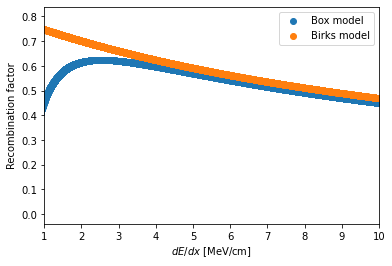

In [6]:
fig, ax = plt.subplots(1, 1)

recomb_birks = tracks_birks[:,i.n_electrons] / (consts.MeVToElectrons * tracks_birks[:,i.dE])
recomb_box = tracks_box[:,i.n_electrons] / (consts.MeVToElectrons * tracks_box[:,i.dE])

ax.scatter(tracks_box[:,i.dEdx], recomb_box, label="Box model")
ax.scatter(tracks_birks[:,i.dEdx], recomb_birks, label="Birks model")
ax.set_xlabel("$dE/dx$ [MeV/cm]")
ax.set_ylabel("Recombination factor")
ax.set_xlim(1,10)
_ = ax.legend()

In [7]:
quenching.quench[blockspergrid,threadsperblock](tracks_np, consts.box)
tracks_quenched = np.copy(tracks_np)
drifting.drift[blockspergrid,threadsperblock](tracks_np)
tracks_drifted = np.copy(tracks_np)

## Electron lifetime
The electrons traveling towards the anode are absorbed by impurities present in the liquid argon. The decrease follows an exponential curve $N_e^{\mathrm{anode}}/N_e=\exp(-t_{\mathrm{drift}}/e_{\mathrm{lifetime}})$.

/global/homes/s/soleti/.conda/envs/numbaenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


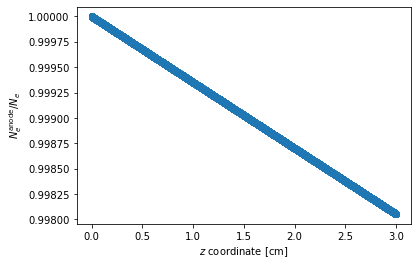

In [8]:
fig, ax = plt.subplots(1, 1)
ax.scatter(tracks_quenched[:,i.z], tracks_drifted[:,i.n_electrons]/tracks_quenched[:,i.n_electrons])
ax.set_ylabel("$N_{e}^{\mathrm{anode}}/N_{e}$")
_ = ax.set_xlabel("$z$ coordinate [cm]")

## Diffusion
The diffusion coefficients (longitudinal and transverse) are proportional to $\sqrt{2t_{\mathrm{drift}}}$ (which in turn is given by $(z_{\mathrm{start}} - z_{\mathrm{anode}})/v_{\mathrm{drift}}$).

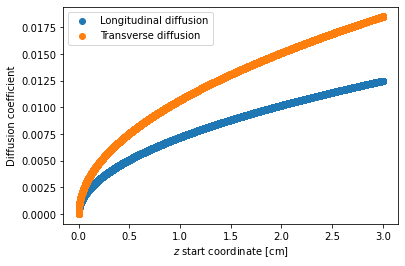

In [9]:
fig, ax = plt.subplots(1, 1)
ax.scatter(tracks_quenched[:,i.z], tracks_np[:,i.long_diff], label="Longitudinal diffusion")
ax.scatter(tracks_quenched[:,i.z], tracks_np[:,i.tran_diff], label="Transverse diffusion")
ax.set_xlabel("$z$ start coordinate [cm]")
ax.set_ylabel("Diffusion coefficient")
# ax.set_ylim(5e-5,1e-3)
# ax.set_yscale("log")
_ = ax.legend()